# Trigger Experiments

Here we try to look for event triggers that became false positives because our event annotation is based on n-ary relation annotation, even though they are not actually false positives.
In n-ary relation annotation a trigger was only annotated as part of a relation if there was atleast one more argument in the same sentence.

We also try to quantify the quality of labeling functions for event triggers that only rely on trigger lists vs. labeling functions that look at the nearest entity/ context words.

In [1]:
import sys
sys.path.append("../")

## Data preparation
We first load the SD4M gold train data, build the trigger examples and add some information to help us during the experiments

In [2]:
import pandas as pd
from wsee.utils import corpus_statistics
sd4m_train = pd.read_json("../data/daystream_corpus/train/train_with_events_and_defaults.jsonl", lines=True, encoding='utf8')
filtered_sd4m_train = sd4m_train[sd4m_train.apply(lambda document: corpus_statistics.has_triggers(document), axis=1)]
corpus_statistics.get_snorkel_event_stats(filtered_sd4m_train)

{'# Docs': 567,
 '# Docs with event triggers': 413,
 '# Event triggers with positive label': 488,
 '# Event triggers with negative label': 289,
 '# Event triggers with abstain': 0,
 'Trigger class frequencies': {'Accident': 59,
  'CanceledRoute': 61,
  'CanceledStop': 25,
  'Delay': 65,
  'Obstruction': 101,
  'RailReplacementService': 22,
  'TrafficJam': 155,
  'O': 289},
 '# Docs with event roles': 413,
 '# Event role with positive label': 2001,
 '# Event roles with negative label': 5284,
 '# Event roles with abstain': 0,
 'Role class frequencies': {'location': 571,
  'delay': 87,
  'direction': 277,
  'start_loc': 377,
  'end_loc': 352,
  'start_date': 35,
  'end_date': 41,
  'cause': 103,
  'jam_length': 135,
  'route': 23,
  'no_arg': 5284}}

In [3]:
from wsee.data import pipeline

df_sd_train, Y_sd_train = pipeline.build_event_trigger_examples(filtered_sd4m_train)

INFO:root:Building event trigger examples
INFO:root:DataFrame has 567 rows
567it [00:00, 684.59it/s]
INFO:root:Number of events: 488
INFO:root:Number of event trigger examples: 777


In [4]:
from wsee.preprocessors import preprocessors

def get_simple_trigger(doc):
    trigger = doc.trigger
    simple_trigger = {
        'text': trigger['text'],
        'entity_type': trigger['entity_type'],
        'char_start': trigger['char_start'],
        'char_end': trigger['char_end']
    }
    return simple_trigger

def add_simple_columns(df):
    df['trigger_sm'] = df.apply(lambda doc: get_simple_trigger(doc), axis=1)
    df['closest_entity'] = df.apply(lambda doc: preprocessors.get_closest_entity_same_sentence(doc), axis=1)
    return df

In [5]:
from wsee import SD4M_RELATION_TYPES
pd.set_option('display.max_colwidth', None)
labeled_sd4m_triggers = df_sd_train.copy()
labeled_sd4m_triggers['label'] = Y_sd_train
labeled_sd4m_triggers['event_type'] = [SD4M_RELATION_TYPES[label_idx] for label_idx in Y_sd_train]
labeled_sd4m_triggers = add_simple_columns(labeled_sd4m_triggers)

## Strategies for the labeling functions
The most straightforward strategy is to build keyword lists (trigger lists) for each event type and check if the text of a potential trigger matches any of the keywords.
Another strategy is to look at the entity type of the physically/syntactically nearest entity to the trigger in the sentence.
There may be very typical context words.

We found that using trigger lists plus fuzzy string matching worked very well. We added some checks to ensure that we comply with the annotation guidelines (event cause does not constitute an event trigger). 
We mostly just checked for required arguments in addition to the trigger text matching.

### Entity type of the nearest entity to the trigger
Here we first look at entity type distributions of the nearest entity to the trigger for each event type and then compare the labeling functions.

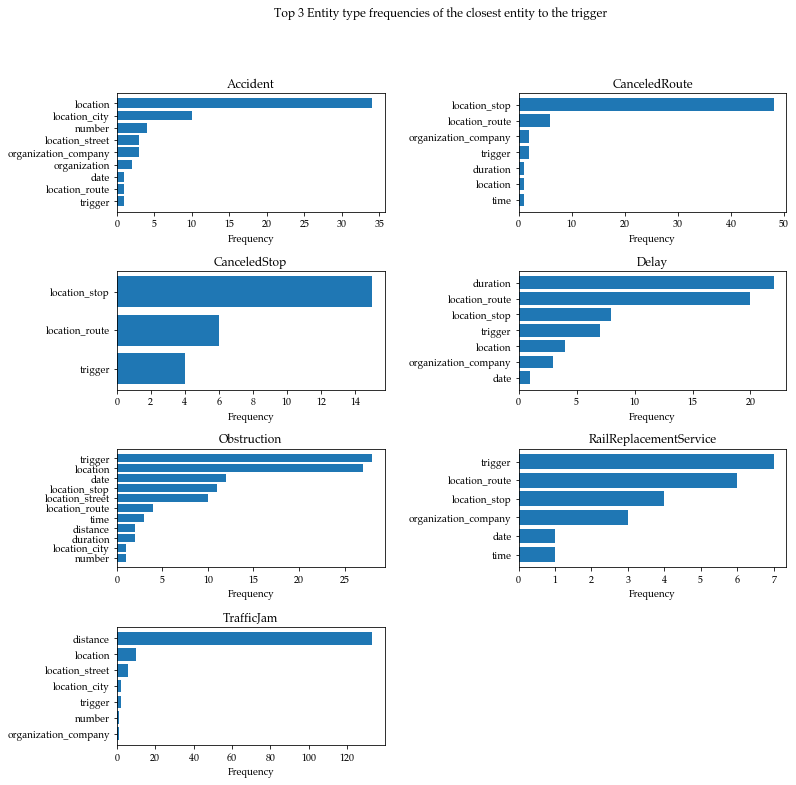

In [6]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams["font.family"] = "Palatino"

fig, ax = plt.subplots(4, 2, figsize=(12, 12))
fig.suptitle('Top 3 Entity type frequencies of the closest entity to the trigger')
flat_axes = ax.flatten()
for label_idx, event_type in enumerate(SD4M_RELATION_TYPES[:-1]):
    rel_rows = labeled_sd4m_triggers[labeled_sd4m_triggers['label'] == label_idx]
    nearest_entity_types = [row['closest_entity']['entity_type'] for idx, row in rel_rows.iterrows() if row['closest_entity']]
    entity_types, counts = np.unique(nearest_entity_types, return_counts=True)
    count_sort_ind = np.argsort(-counts)
    entity_types = entity_types[count_sort_ind]
    counts = counts[count_sort_ind]
    y_pos = np.arange(len(entity_types))
    flat_axes[label_idx].barh(entity_types, counts, align='center')
    flat_axes[label_idx].invert_yaxis()  # labels read top-to-bottom
    flat_axes[label_idx].set_xlabel('Frequency')
    flat_axes[label_idx].set_title(event_type)
    plt.subplots_adjust(wspace=.5, hspace=.5)
fig.delaxes(ax[3,1])
plt.show()

We observed that the `duration` entity type was the most frequent entity type of the closest entity to `Delay` event triggers and the `distance` entity type was the most frequent entity type of the closest entity to  `TrafficJam` event triggers. While both `distance` and `duration` entities were sometimes observed as the entity type of the closest entity to the trigger for the `Obstruction` (2x `duration`, 2x `distance`) and `CanceledRoute` (1x `duration`) the much higher frequencies for `Delay` (> 20x `duration`) `TrafficJam` (> 120x `distance`) set them apart from the other event types.
This makes sense intuitely as a `duration` entity may be a `delay argument` to the `Delay` trigger and `distance` entity may be a `jam_length` argument to the `TrafficJam` trigger.

We did not observe similarly characteristic entity types of the closest entity to the triggers for the other event types.
`Accident` event triggers often co-occur with `location` entities, but so do `Obstruction` event triggers. 
`CanceledRoute` event triggers and `CanceledStop` event triggers often co-occur with `location_stop` entities.
`Obstruction` event triggers and `RailReplacementService` event triggers often co-occur with `trigger` entities.

Based on this observation we compare 2 strategies for labeling functions for `Delay` and `TrafficJam` event types.
1. Trigger list with fuzzy string matching (what we ended up using for the trigger labeling)
2. Entity type of closest entity to the trigger

In [7]:
from snorkel.labeling import labeling_function

Accident = 0
CanceledRoute = 1
CanceledStop = 2
Delay = 3
Obstruction = 4
RailReplacementService = 5
TrafficJam = 6
O = 7
ABSTAIN = -1


@labeling_function(pre=[preprocessors.pre_closest_entity_same_sentence])
def delay_duration_check(x):
    if x['closest_entity'] and x['closest_entity']['entity_type'] == 'duration':
        return Delay
    else:
        return ABSTAIN

@labeling_function(pre=[preprocessors.pre_closest_entity_same_sentence])
def trafficjam_distance_check(x):
    if x['closest_entity'] and x['closest_entity']['entity_type'] == 'distance':
        return TrafficJam
    else:
        return ABSTAIN

In [8]:
from wsee.labeling import event_trigger_lfs as trigger_lfs
from snorkel.labeling import PandasLFApplier

lfs = [
    delay_duration_check,
    trigger_lfs.lf_delay_cat,  # trigger list + some checks for negation & parentheses
    trigger_lfs.lf_delay_priorities,  # trigger list + some checks for negation & parentheses + lower priority trigger list (ignore lower priority trigger when encountering multiple potential delay triggers)
    trigger_lfs.lf_delay_duration, # trigger list + some checks for negation & parentheses + occurence of duration entity
    trafficjam_distance_check,
    trigger_lfs.lf_trafficjam_cat,  # trigger list + check for parentheses
    trigger_lfs.lf_trafficjam_street,  # trigger list + check for parentheses and occurence of location street entity
    trigger_lfs.lf_trafficjam_order  # trigger list + check for parentheses, check for other preceding TrafficJam trigger
] 
applier = PandasLFApplier(lfs)

In [9]:
L_sd_train = applier.apply(df_sd_train)

100%|██████████| 777/777 [00:08<00:00, 92.53it/s]


In [10]:
from snorkel.labeling import LFAnalysis

LFAnalysis(L_sd_train, lfs).lf_summary(Y_sd_train)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
delay_duration_check,0,[3],0.033462,0.028314,0.0,22,4,0.846154
lf_delay_cat,1,[3],0.083655,0.083655,0.0,65,0,1.000000
lf_delay_priorities,2,[3],0.087516,0.083655,0.0,65,3,0.955882
lf_delay_duration,3,[3],0.072072,0.072072,0.0,56,0,1.000000
trafficjam_distance_check,4,[6],0.176319,0.172458,0.0,133,4,0.970803
lf_trafficjam_cat,5,[6],0.203346,0.203346,0.0,155,3,0.981013
lf_trafficjam_street,6,[6],0.199485,0.199485,0.0,153,2,0.987097
lf_trafficjam_order,7,[6],0.196911,0.196911,0.0,152,1,0.993464


The SD4M train set contains 65 `Delay`events and 155 `TrafficJam` events. Given that the trigger lists were refined using the SD4M training data, the recall is expectedly high.
The strategy of only checking whether the entity type of the closest entity to a potential `TrafficJam` trigger is `distance` worked fairly well with 133/155 recall and 133/137 precision.
It did not work as well for the `Delay` event type. While the precision of 22/26 was good, the recall of 22/65 is quite low. 
However both approaches did improve on the simpler, more straightforward strategy of matching the trigger text to trigger lists.

### Error analysis:

In [11]:
from wsee.labeling import error_analysis

In [12]:
error_analysis.get_false_positives(labeled_df=labeled_sd4m_triggers, lf_outputs=L_sd_train, lf_index=0, label_of_interest=3)[['text', 'trigger', 'closest_entity', 'event_type']]  # Delay - duration

,text,trigger,closest_entity,event_type
26,Vier Wochen Bus statt Bahn: Bauarbeiten an den Gleisen der Saalbahn zwischen Orlamünde und Saalfeld https://t.co/uzSDntGckm\n,"{'id': 'c/e1d11faf-99a0-4271-9200-1e13d4ab6653', 'text': 'Bauarbeiten', 'entity_type': 'trigger', 'start': 6, 'end': 7, 'char_start': 28, 'char_end': 39}","{'id': 'c/cec8c316-f0b5-4825-a788-f21172061d38', 'text': 'Vier Wochen', 'entity_type': 'duration', 'start': 0, 'end': 2, 'char_start': 0, 'char_end': 11}",Obstruction
83,"rhein_sieg #529\n#529 / Hennef Linie 529, 17:48 Uhr ab Hennef hat auf Grund von Polizeieinsatz ca. 20 Minuten Verspätung. …\n","{'id': 'c/9bf3f4af-bfd7-4ef8-84b2-3fbc6c1e47d4', 'text': 'Polizeieinsatz', 'entity_type': 'trigger', 'start': 20, 'end': 21, 'char_start': 79, 'char_end': 93}","{'id': 'c/1de4ba5c-b2b9-4752-b2fe-cbec6ced0c5f', 'text': '20 Minuten', 'entity_type': 'duration', 'start': 22, 'end': 24, 'char_start': 98, 'char_end': 108}",O
902,#RE4 wird ab #Düsseldorf Hbf (17:26) bis #Mönchengladbach (17:48) ohne Halt umgeleitet.Mit 20 Minuten Verspätung muss in MG gerechnet werden\n,"{'id': 'c/0e68656e-bb16-44ba-899b-d96194262c7b', 'text': 'umgeleitet.Mit', 'entity_type': 'trigger', 'start': 15, 'end': 16, 'char_start': 76, 'char_end': 90}","{'id': 'c/eabcfcc9-97ae-4b28-9830-e10b91fef00d', 'text': '20 Minuten', 'entity_type': 'duration', 'start': 16, 'end': 18, 'char_start': 91, 'char_end': 101}",CanceledRoute
1156,Die A4 Köln Richtung Aachen ist zwischen Kreuz Aachen und Grenzübergang Vetschau nach einem Unfall in den Niederlanden voraussichtlich noch mehrere Stunden gesperrt. Zurzeit 10km Stau. Sie sollten großräumig umfahren.\n,"{'id': 'c/a9687f89-d922-448f-9270-d9eca79a1b6d', 'text': 'gesperrt', 'entity_type': 'trigger', 'start': 22, 'end': 23, 'char_start': 156, 'char_end': 164}","{'id': 'c/f85b8f6c-2217-416a-8cc3-7f3195794e14', 'text': 'mehrere Stunden', 'entity_type': 'duration', 'start': 20, 'end': 22, 'char_start': 140, 'char_end': 155}",Obstruction


In [13]:
error_analysis.get_false_positives(labeled_df=labeled_sd4m_triggers, lf_outputs=L_sd_train, lf_index=4, label_of_interest=6).iloc[0:2][['text', 'trigger', 'closest_entity', 'event_type']]  # TrafficJam - distance

,text,trigger,closest_entity,event_type
520,"Die A96 Lindau Richtung München ist zwischen Lindau und Sigmarszell wegen Bergungsarbeiten gesperrt, 3 km Stau\n","{'id': 'c/2e48c677-a7a5-41f6-a7e7-c8bcfb0edb6e', 'text': 'gesperrt', 'entity_type': 'trigger', 'start': 12, 'end': 13, 'char_start': 91, 'char_end': 99}","{'id': 'c/5284324e-9d7c-40da-897c-518cebd756b6', 'text': '3 km', 'entity_type': 'distance', 'start': 14, 'end': 16, 'char_start': 101, 'char_end': 105}",Obstruction
665,"A8 Karlsruhe Richtung Stuttgart zwischen Rutesheim und Leonberg-West ein defekter LKW, die rechte Spur ist gesperrt, 2 km Stau\n","{'id': 'c/02927d1e-95a2-47be-995a-3eec320c1a8a', 'text': 'gesperrt', 'entity_type': 'trigger', 'start': 18, 'end': 19, 'char_start': 107, 'char_end': 115}","{'id': 'c/1f937f4f-2eef-47fa-97de-2a10cee71c39', 'text': '2 km', 'entity_type': 'distance', 'start': 20, 'end': 22, 'char_start': 117, 'char_end': 121}",O


For both `Delay` & `duration` and `TrafficJam` & `distance` there were false positives, where the closest entity to the trigger was of the relevant entity type, but the trigger was of a different event type.

## Triggers that were not annotated as part of n-ary relation annotation
Here we manually examine a sample of 100 documents and count the number of event triggers and compare it the number of annotated event triggers (trigger argument from the n-ary relations).
According the annotation guidelines triggers should only be annotated if a relation is expressed in the sentence (ie. if you annotate a relation, also annotate triggers, if available). Furthermore only annotate one event in a sentence if one of the events is only mentioned as a cause and its occurence is not expressed explicitly.
E.g.: "wegen Notarzteinsatz gesperrt" - only annotate "gesperrt"

Alternative: compare labeling functions that check for required arguments vs. labeling functions that do not

In [14]:
sample_docs = pd.read_json("../data/daystream_corpus/train_sample.jsonl", lines=True, encoding='utf8')

In [15]:
from wsee import SD4M_RELATION_TYPES
import numpy as np

def get_simple_entities(x):
    simple_entities = []
    sorted_entities = sorted(x['entities'], key=lambda k: k['start'])
    for entity in sorted_entities:
        simple_entity = {
            'text': entity['text'],
            'entity_type': entity['entity_type'],
            'start': entity['start'],
            'end': entity['end']
        }
        simple_entities.append(simple_entity)
    return simple_entities

def get_simple_triggers(x):
    simple_triggers = []
    for trigger in x['event_triggers']:
        entity = preprocessors.get_entity(trigger['id'], x['entities'])
        simple_trigger = {
            'text': entity['text'],
            'entity_type': entity['entity_type'],
            'start': entity['start'],
            'end': entity['end'],
            'event_type': SD4M_RELATION_TYPES[np.argmax(trigger['event_type_probs'])]
        }
        simple_triggers.append(simple_trigger)
    return simple_triggers

def add_simple_columns2(df):
    df['simple_entities'] = df.apply(lambda doc: get_simple_entities(doc), axis=1)
    df['simple_triggers'] = df.apply(lambda doc: get_simple_triggers(doc), axis=1)
    return df

In [16]:
sample_docs = add_simple_columns2(sample_docs)

In [17]:
sample_docs.iloc[95:100][['text', 'simple_entities', 'simple_triggers']]

,text,simple_entities,simple_triggers
95,ich werde wahrscheinlich auch bis 50 liegen bleiben & dann wie ein Tornado durchs Haus Fegen damit ich alles noch schaffe\n,"[{'text': '50', 'entity_type': 'number', 'start': 5, 'end': 6}, {'text': 'Tornado', 'entity_type': 'trigger', 'start': 12, 'end': 13}]",[]
96,Wegen Verspätung des Eingangszuges verkehrtb 82121 von Hamburg nach Uelzen mit einer Verspätung von 15 Minuten ab Hamburg. Planm. Abfahrt\n,"[{'text': '82121', 'entity_type': 'location_route', 'start': 5, 'end': 6}, {'text': 'Hamburg', 'entity_type': 'location_stop', 'start': 7, 'end': 8}, {'text': 'Uelzen', 'entity_type': 'location_stop', 'start': 9, 'end': 10}, {'text': 'Verspätung', 'entity_type': 'trigger', 'start': 12, 'end': 13}, {'text': '15 Minuten', 'entity_type': 'duration', 'start': 14, 'end': 16}, {'text': 'Hamburg', 'entity_type': 'location_stop', 'start': 17, 'end': 18}]","[{'text': 'Verspätung', 'entity_type': 'trigger', 'start': 12, 'end': 13, 'event_type': 'Delay'}]"
97,RT @SPIEGELONLINE: Eine Lawine hat in Frankreich sieben Menschen in den Tod gerissen - darunter mindestens drei Deutsche http://t.co/0hA7XJ…\n,"[{'text': '@SPIEGELONLINE', 'entity_type': 'organization_company', 'start': 1, 'end': 2}, {'text': 'Lawine', 'entity_type': 'trigger', 'start': 4, 'end': 5}, {'text': 'Frankreich', 'entity_type': 'location', 'start': 7, 'end': 8}, {'text': 'sieben', 'entity_type': 'number', 'start': 8, 'end': 9}, {'text': 'drei', 'entity_type': 'number', 'start': 17, 'end': 18}]","[{'text': 'Lawine', 'entity_type': 'trigger', 'start': 4, 'end': 5, 'event_type': 'O'}]"
98,A7 Flensburg Richtung Hamburg zwischen Hamburg-Volkspark und dem Elbtunnel 4 km stockender Verkehr\n,"[{'text': 'A7', 'entity_type': 'location_street', 'start': 0, 'end': 1}, {'text': 'Flensburg', 'entity_type': 'location_city', 'start': 1, 'end': 2}, {'text': 'Hamburg', 'entity_type': 'location_city', 'start': 3, 'end': 4}, {'text': 'Hamburg-Volkspark', 'entity_type': 'location', 'start': 5, 'end': 8}, {'text': 'Elbtunnel', 'entity_type': 'location', 'start': 10, 'end': 11}, {'text': '4 km', 'entity_type': 'distance', 'start': 11, 'end': 13}, {'text': 'stockender Verkehr', 'entity_type': 'trigger', 'start': 13, 'end': 15}]","[{'text': 'stockender Verkehr', 'entity_type': 'trigger', 'start': 13, 'end': 15, 'event_type': 'TrafficJam'}]"
99,Bus 66 Richtung Geschwister-Scholl-Gymnasium mit der nächsten Haltestelle In der Werre hat 0:12:00 Verspätung\n,"[{'text': 'Bus 66', 'entity_type': 'location_route', 'start': 0, 'end': 2}, {'text': 'Geschwister-Scholl-Gymnasium', 'entity_type': 'location_stop', 'start': 3, 'end': 8}, {'text': 'In der Werre', 'entity_type': 'location_stop', 'start': 12, 'end': 15}, {'text': '0:12:00', 'entity_type': 'duration', 'start': 16, 'end': 17}, {'text': 'Verspätung', 'entity_type': 'trigger', 'start': 17, 'end': 18}]","[{'text': 'Verspätung', 'entity_type': 'trigger', 'start': 17, 'end': 18, 'event_type': 'Delay'}]"


In 5 document batches
"fällt" "aus": both as trigger, but only the former as event trigger

Without regard for relations/additional arguments:
- Triggers : 
    - 6, 7, 10, 6, 10, 9, 8, 6, 6, 10, 6, 16, 8, 9, 11, 6, 9, 6, 7, 4  
- Event triggers: 
    - 4, 5, 5, 4, 7, 7, 3, 4, 4, 5, 5, 9, 6, 8, 7, 4, 4, 4, 4, 3
- Relevant instances:
    - 0: "Hildesheim Von Morgen bis einschliesslich Freitag ... gesamte Busverkehr eingestellt" (CanceledRoute with no location argument)
    - 8: "...Umleitung führt ab Lembeck über die U25" (Obstruction)
    - 11: "...Als Ersatz fahren Busse zwischen Freilassing und Berchtesgaden Hbf." (RRS with no location argument)
    - 12: "...Dort ist wegen Bergungsarbeiten nur ein Fahrstreifen frei" (Obstruction event with no location argument, lane closure not explicit enough?)
    - 17: "...Dort ist wegen #Bauarbeiten nur eine Spur frei" (Obstruction with no location argument, lane closure not explicit enough?)
    - 21: "...Als Ersatz fahren jeweils Busse zwischen Freilassing und Berchtesgaden Hbf" (RRS with no location argument)
    - 23: "...Der Halt in Lüneburg fällt aus." (CanceledStop)
    - 48: "...Die Busse halten nicht in Berlin Ostbahnhof." (CanceledStop)
    - 50: "...Die Umleitung führt für den Nahverkehr ab dem Dreieck Walsrode über die U53" (Obstruction with no location argument)
    - 52: "...*behindert* eine Unfallstelle den Verkehr" (Obstruction)
    - 59: "...nutzen Sie den Schienenersatzverkehr in diesem Abschnitt" (RRS not explicit, no location argument)
    - 61: "...Als Ersatz nutzen Sie den Bus von Dresden Hbf" (RRS with no location argument)
    - 65: "...stockender Verkehr an einer 10 km Stau an" (double TrafficJam)
    - 67: "A8 Karlsruhe Richtung Stuttgart zwischen Rutesheim und Leonberg-West ein defekter LKW, die rechte Spur ist *gesperrt*, 2 km Stau" (Obstruction missing)
    - 69: "...Wegen Bauarbeiten ist nur ein Fahrstreifen frei" (Obstruction)
    - 71: "Vollsperrung der #A100 in Fahrtrichtung Nord, Grund: schwerer Unfall" (Accident as cause)
    - 72: "kein Halt in Hamburg Hbf und Hamburg Dammtor..." (CanceledStop)
    - 72: "...Zugausfall Hamburg-Harburg > Hamburg-Altona..." (CanceledRoute with no location argument)
    - 79: "Vier Wochen Bus statt Bahn: Bauarbeiten..." (RailReplacementService with no location argument
    - 85: "...Der Halt in Lüneburg fällt aus..." (CanceledStop)
    - 91: "...Mit 20 Minuten Verspätung muss in MG gerechnet..." (Delay with no location argument)
    - 94: "...Stau nach einem Unfall" (Accident as cause)

Annotation:
- Triggers: 
    - 5, 6, 8, 5, 8, 9, 8, 6, 6, 9, 4, 15, 7, 8, 9, 5, 9, 5, 6, 4
- Event triggers: 
    - 3, 4, 3, 3, 5, 7, 3, 4, 4, 6, 3, 8, 5, 5, 4, 3, 4, 3, 2, 3
    
Sum

- 142 triggers in annotation vs. 160 manually determined triggers
- 82 event triggers in annotation vs. 102 manually determined event triggers
    - 11 had no required location argument
    - 3 were causes or duplicates
    - 6 were missed (2 of which "Umleitung", detour should have been labeled as Obstruction?)

